**Lista de Ejercicios 3**


Grupo:
1. Mayra Gavilán (20131530)
2. Milagros Meza (20120186)
3. Paola Cordova (20130365)
4. Serghi Arista (20125341)

**Pregunta 1**

Brinde una explicación detallada del algoritmo que se utiliza para implementar un Árbol de Regresión.

**1) División de los datos**

El algoritmo comienza con todos los datos en un nodo raíz y busca la característica (o variable) que mejor divide los datos en subconjuntos más homogéneos en términos de la variable de respuesta (el valor que estamos tratando de predecir).

**2) Criterio de división**

Para determinar la mejor característica de división, se utiliza un criterio de impureza como el error cuadrático medio (MSE), que mide la dispersión de los valores de la variable de respuesta en un nodo. Se calcula la reducción en la impureza (o la ganancia en la pureza) que se obtiene al dividir los datos según una característica específica.

**3) División recursiva**

Una vez que se selecciona la mejor característica de división, los datos se dividen en dos o más subconjuntos en función de los valores de esa característica. Este proceso se repite recursivamente en cada subconjunto hasta que se alcanza un criterio de parada, como una profundidad máxima del árbol, un número mínimo de muestras en cada nodo hoja o una impureza mínima.

**4) Predicción**

Una vez construido el árbol, para hacer una predicción para una nueva observación, se sigue el árbol desde la raíz hasta llegar a una hoja, y se predice el valor promedio de las observaciones de entrenamiento en esa hoja.

**5) Regularización**

Para evitar el sobreajuste (overfitting), se pueden aplicar técnicas de regularización como la poda del árbol (eliminación de nodos innecesarios), la limitación de la profundidad máxima del árbol o la especificación de un número mínimo de muestras requeridas para dividir un nodo.

**Pregunta 2**

In [ ]:
import pandas as pd
import numpy as np
import warnings

import six
import sys
from IPython.display import Image
sys.modules['sklearn.externals.six'] = six
import pydot
import matplotlib.pyplot as plt

# Scikit-Learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.externals.six import StringIO
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

1. Divida los datos en conjuntos de entrenamiento y de prueba.

In [ ]:
carseats = pd.read_csv('https://raw.githubusercontent.com/qlabpucp/datasets/main/datasets/carseats.csv')
carseats.ShelveLoc = pd.factorize(carseats.ShelveLoc)[0]
carseats = pd.get_dummies(carseats, dtype='int')
carseats = carseats.drop(columns = ['Unnamed: 0', 'Urban_No', 'US_No'])
carseats = carseats.dropna()
carseats = carseats.reindex()
carseats.shape

(400, 11)

In [ ]:
target = [ 'Sales' ]
predictors = [ var for var in carseats.columns if var not in target ]

X_train, X_test, Y_train, Y_test = train_test_split(carseats[predictors], carseats[target], test_size=0.3, random_state=0)

In [ ]:
Y_train = Y_train.values.ravel()
Y_test = Y_test.values.ravel()

2. Ajuste un  arbol de regresion al conjunto de entrenamiento. Interprete los resultados. ¿Que valor de MSE se obtiene para el conjunto de prueba?

In [ ]:
regr = DecisionTreeRegressor(max_depth=3)
regr.fit(X_train, Y_train)
Y_pred = regr.predict(X_test)

In [ ]:
def print_tree(estimator, features, class_names=None, filled=True):

    tree = estimator
    names = features
    color = filled
    classn = class_names
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

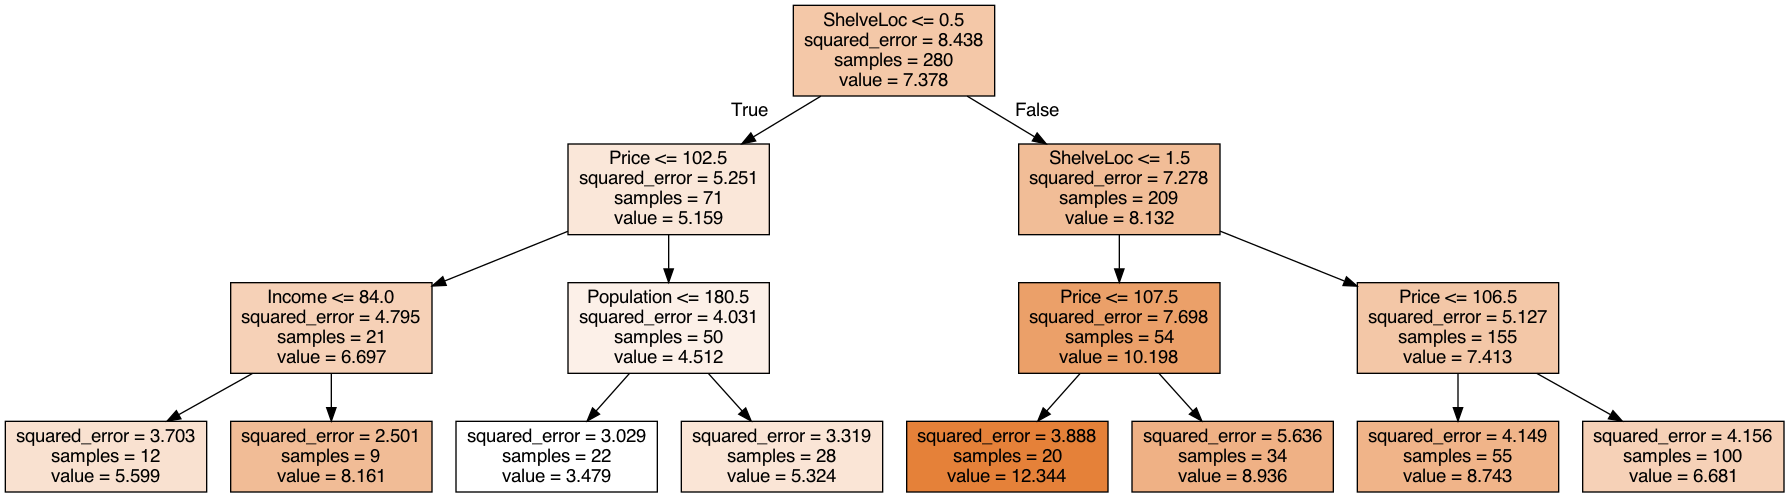

In [ ]:
graph, = print_tree(regr, features=predictors)
Image(graph.create_png())

In [ ]:
MSE = round( mean_squared_error(Y_test, Y_pred), 3 )
print('MSE:', MSE)

MSE: 3.803


3. Utilice el m etodo Bagging para analizar estos datos. ¿Qu e valor de MSE obtiene para el conjunto de prueba?

In [ ]:
bagging = BaggingRegressor(max_features=10, random_state=1)
bagging.fit(X_train, Y_train)

Y_pred = bagging.predict(X_test)

MSE_bag = round( mean_squared_error(Y_test, Y_pred), 3 )
print('MSE con método Bagging:', MSE_bag)

MSE con método Bagging: 2.777


4. Utilice el metodo Random Forest para analizar los datos. Repita el procedimiento descrito en el punto 3. Describa el efecto de m, el nu mero de variables consideradas en cada division, sobre la tasa de error obtenida. Utilice la funcion features importance() para determinar que variables son las mas importantes.

In [ ]:
max_features_values = [3, 5, 10]

MSE_rf_values = []

for max_features in max_features_values:
    rf = RandomForestRegressor(max_features=max_features, random_state=1)
    rf.fit(X_train, Y_train)

    Y_pred = rf.predict(X_test)

    MSE = mean_squared_error(Y_test, Y_pred)
    MSE_rf_values.append(MSE)

for i, max_features in enumerate(max_features_values):
    print(f"MSE para m={max_features}: {MSE_rf_values[i]}")

MSE para m=3: 2.7264667105833333
MSE para m=5: 2.3063116554999983
MSE para m=10: 2.19104943


De los resultados se observa que un cambio en el número de variables consideradas en cada división afecta la tasa de error obtenida; a mayor número de variables menor el MSE obtenido. En este caso con el número máximo de variables (10) alcanzamos el menor MSE (2.19).

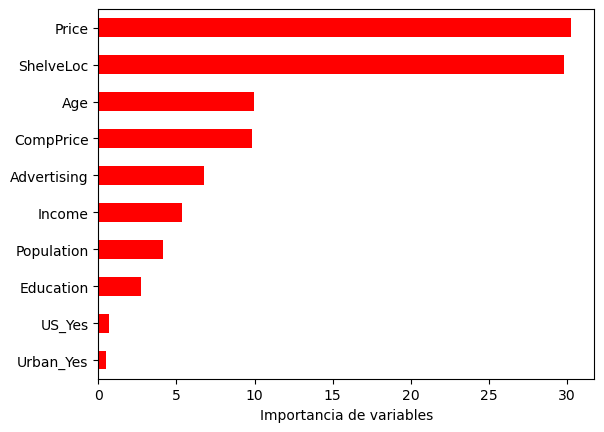

In [ ]:
Importance = pd.DataFrame({'Importancia':rf.feature_importances_*100}, index=predictors)
Importance.sort_values('Importancia', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Importancia de variables')
plt.gca().legend_ = None

Al usar la función features_importance(), observamos que las dos (02) variables más importantes para la predicción de ventas de asientos de coche para niños son el precio y la calidad de la ubicación de la estantería para los asientos de coche de cada sitio; seguidos por la edad media de la población local y el precio cobrado por el competidor en cada ubicación.

5. Utilice el metodo Gradient Boosting. Repita el procedimiento descrito en el punto 4.

In [ ]:
n_estimators_values = [200, 500, 1000]
learning_rate_values = [0.01, 0.1, 0.5]

results = []

for learning_rate in learning_rate_values:
    for n_estimators in n_estimators_values:

        boost = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=1)
        boost.fit(X_train, Y_train)

        Y_pred = boost.predict(X_test)

        mse = mean_squared_error(Y_test, Y_pred)

        results.append({'Tasa de aprendizaje': learning_rate, 'Num Estimadores': n_estimators, 'MSE GB': mse})

results_df = pd.DataFrame(results)

results_df

,Tasa de aprendizaje,Num Estimadores,MSE GB
0,0.01,200,2.922813
1,0.01,500,2.171057
2,0.01,1000,2.083814
3,0.10,200,2.058998
4,0.10,500,2.117749
5,0.10,1000,2.132627
6,0.50,200,2.433816
7,0.50,500,2.440724
8,0.50,1000,2.440726


Hemos evaluado 9 casos para 3 tasas de aprendizaje y 3 números diferentes de estimadores. Al respecto, observamos que con la menor tasa de aprendizaje, el MSE disminuye a mayor numero de estimadores; mientras que con una tasa de aprendizaje de 0.1 pasa lo contrario y con una tasa de aprendizaje de 0.5 casi no hay movimiento. De los resultados, el mejor MSE nos lo da la tasa de aprendizaje 0.1 con un número de estimadores de 200 (2.07), seguido de la tasa de aprendizaje 0.01 con un número de estimadores de 1000 (2.08).

**Pregunta 3**

Aplique los métodos Boosting, Bagging y Random Forest a una dataset de su elección. Asegúrese de dividir los datos en los conjuntos de entrenamiento y de prueba, ajustar los modelos sobre el conjunto de entrenamiento y evaluar su desempeño sobre el conjunto de prueba. ¿Cuán precisos son los resultados si los compara con métodos regresión lineal/logística y/o métodos de Regularización? ¿Cuál de todos los modelos implementados muestra un mejor desempeño?

Primero, importaremos las bibliotecas necesarias y cargaremos el conjunto de datos de diabetes de scikit-learn. Luego dividiremos los datos en conjuntos de entrenamiento y prueba. Posteriormente, entrenaremos y evaluaremos varios modelos, incluyendo Boosting, Bagging, Random Forest, regresión lineal y regresión logística. Finalmente, compararemos los resultados para determinar qué modelo muestra un mejor desempeño.

In [ ]:
# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

# Cargar conjunto de datos de diabetes
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Normalizar los datos (solo para modelos lineales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Inicializar modelos
models = [
    ('Boosting', GradientBoostingRegressor(random_state=0)),
    ('Bagging', BaggingRegressor(random_state=0)),
    ('Random Forest', RandomForestRegressor(random_state=0)),
    ('Linear Regression', LinearRegression()),
    ('Logistic Regression', LogisticRegression(max_iter=1000))
]

# Almacenar resultados en un diccionario
results = []
for name, model in models:
    model.fit(X_train, y_train)
    if name == 'Logistic Regression':
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        results.append({'Model': name, 'RMSE': np.nan, 'Accuracy': accuracy, 'R Squared': np.nan})
    else:
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results.append({'Model': name, 'RMSE': rmse, 'Accuracy': np.nan, 'R Squared': r2})

# Crear DataFrame con los resultados
df_results = pd.DataFrame(results)

# Imprimir DataFrame de resultados
print("Desempeño de los modelos:")
print(df_results)

Desempeño de los modelos:
                 Model       RMSE  Accuracy  R Squared
0             Boosting  63.811841       NaN   0.205926
1              Bagging  66.898933       NaN   0.127237
2        Random Forest  61.239694       NaN   0.268652
3    Linear Regression  58.517171       NaN   0.332233
4  Logistic Regression        NaN       0.0        NaN


El motivo por el que se utiliza la precisión (accuracy) en lugar del error cuadrático medio (RMSE) para evaluar el desempeño de la regresión logística es porque la regresión logística es un algoritmo de clasificación, no de regresión.

El RMSE es una métrica comúnmente utilizada para evaluar modelos de regresión, ya que mide la diferencia entre los valores predichos por el modelo y los valores reales. Sin embargo, en el caso de la regresión logística, estamos tratando de predecir clases discretas (por ejemplo, '0' o '1'), no valores continuos. Por lo tanto, la precisión es una métrica más apropiada para evaluar la calidad de las predicciones de un modelo de clasificación.

**Pregunta 4**

Implemente una red neuronal con la database *Default*. Use una capa oculta con 10 unidades y regularización por dropout. Compare el desempeño de clasificación con respecto al de la regresión lineal.

In [ ]:
# Basic
import numpy as np
import pandas as pd
import requests
import json

# Plotting
import matplotlib.pyplot as plt

# Scikit-Learn
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.linear_model import LinearRegression

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing import sequence

# TensorFlow
from tensorflow.keras.datasets import mnist, cifar100, imdb
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Cargar datos
default = pd.read_csv('https://raw.githubusercontent.com/qlabpucp/datasets/main/datasets/default.csv')
default = default.dropna()
default = default.drop(columns = ['Unnamed: 0'])
default = pd.get_dummies(default, dtype='int')
default = default.drop(columns = ['default_No', 'student_No'])
default.rename(columns={'default_Yes': 'default', 'student_Yes': 'student'}, inplace=True)
default = default.reindex()
default.shape

(10000, 4)

In [ ]:
default['default'].value_counts()

default
0    9667
1     333
Name: count, dtype: int64

In [ ]:
# Dividir dataset en conjuntos de entrenamiento y de prueba
target = [ 'default' ]
predictors = [ var for var in default.columns if var not in target ]

X_train, X_test, y_train, y_test = skm.train_test_split(default[predictors], default[target], test_size=0.33, random_state=0)

In [ ]:
# Definir y compilar la red neuronal
model = keras.Sequential([
    keras.layers.Dense(10, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

C:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Entrenar la red neuronal
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7766 - loss: 3106.2744 - val_accuracy: 0.9627 - val_loss: 202.2501
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 850us/step - accuracy: 0.7714 - loss: 1533.0293 - val_accuracy: 0.9627 - val_loss: 186.1494
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.7689 - loss: 691.9206 - val_accuracy: 0.9627 - val_loss: 133.4593
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.7822 - loss: 235.9101 - val_accuracy: 0.9627 - val_loss: 86.7965
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.7714 - loss: 93.9233 - val_accuracy: 0.9627 - val_loss: 45.9940
Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - accuracy: 0.9685 - loss: 26.0805 - val_accuracy: 0.9627 - val_loss: 17.3702
Epoch 7/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - accuracy: 0.9682 - loss: 9.3783 - val_accuracy: 0.9627 - val_loss: 2.3869
Epoch 8/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.973

In [ ]:
# Evaluar desempeño
loss, accuracy = model.evaluate(X_test, y_test)
print("Accuracy of Neural Network:", accuracy)

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - accuracy: 0.9624 - loss: 0.2545
Accuracy of Neural Network: 0.9627272486686707


In [ ]:
# Entrenar una regresión lineal y evaluar su desempeño
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
mse_linear = round( mean_squared_error(y_test, y_pred_linear), 3 )
accuracy_linear = accuracy_score(y_test, np.round(y_pred_linear))
print("MSE of Linear Regression:", mse_linear)
print("Accuracy of Linear Regression:", accuracy_linear)

MSE of Linear Regression: 0.031
Accuracy of Linear Regression: 0.9627272727272728


In [ ]:
if accuracy > accuracy_linear:
    print("La red neuronal supera a la regresión lineal en términos de precisión.")
elif accuracy < accuracy_linear:
    print("La regresión lineal supera a la red neuronal en términos de precisión.")
else:
    print("Ambos modelos tienen la misma precisión.")

La regresión lineal supera a la red neuronal en términos de precisión.


**Pregunta 5**

Considere la implementaci ́on del modelo de Redes Neuronales Convolucionales (CNN) utilizando la dataset CIFAR 100 presentada en el notebook de clases. En esta implementaci ́on inicial, se alcanz ́o un Accuracy aproximado de 0.44. Su tarea es desarrollar una nueva implementaci ́on que supere este valor de Accuracy. Para lograrlo, se le anima a experimentar con los siguientes aspectos del modelo:

• Arquitectura del Modelo: Puede considerar la adición de más capas convolucionales y de pooling, incrementar el número de filtros por capa, o modificar el tamaño del kernel.
• Regularización: Experimente con diferentes tasas de dropout para prevenir el sobreajuste.
• Entrenamiento: Pruebe con distintos taman ̃os de batch que puedan influir en la convergencia del modelo durante el entrenamiento.
• Optimización: Evalúe el uso de diferentes algoritmos de optimización para verificar si mejoran la precisión del modelo.
La meta es ajustar estos parámetros para superar el Accuracy de 0.44 previamente alcanzado. Documente todas las modificaciones realizadas y los resultados obtenidos.

Vamos a cargar el dataset CIFAR 100, a normalizar la data y a convertir las variables a categóricas:

In [1]:
# Basic
import numpy as np
import pandas as pd
import requests
import json

# Plotting
import matplotlib.pyplot as plt

# Scikit-Learn
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sklearn.model_selection as skm
import sklearn.linear_model as skl

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing import sequence

# TensorFlow
from tensorflow.keras.datasets import mnist, cifar100, imdb
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
print(x_train.shape)
print(x_test.shape)

# Normalize data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Convert labels to categorical
y_train = to_categorical(y_train, num_classes=100)
y_test = to_categorical(y_test, num_classes=100)

169001437/169001437 [==============================] - 4s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


En primer lugar, para mejorar el rendimiento del modelo, que actualmente tiene un accuracy de 0.44, se va a adoptar la estrategia de modificar la arquitectura del modelo. Esto implica aumentar el número de capas convolucionales y de pooling o modificar el tamaño del kernel. En segundo lugar, se va a adoptar la estrategia de reducir el overfitting mediante la regularización. En ese sentido, se van a introducir capas de dropout, lo que significa eliminar neuronas de manera aleatoria entre las capas. Esto puede ayudar a contrarrestar el problema de overfitting y, como resultado, aumentar el accuracy del modelo. En tercer lugar, también se adoptó la estrategia de modificar los parámetros de entrenamiento como el tamaño de épocas o el tamaño de batchs. Se va a modificar el número de ambos a fin de encontrar si se podía obtener una mejor precisión del modelo. Finalmente, se va a explorar con otro algoritmo de optimización llamado Adam, el cual es conocido por su eficiencia, a fin de evaluar su rendimiento en el modelo.

Los mejores resultados se encuentran en el **Modelo 4**, el cual alcanza un **accuracy de 0.4923**. Las modificaciones realizadas incluyen:

1.   La adicción de 3 capas de dropout, cada una con una tasa del 20%. La primera se aplica a la segunda capa, la segunda a la tercera capa y la tercera a la cuarta capa. Estas capas de dropout ayudan a prevenir el sobreajuste al desactivar temporalmente una fracción de las neuronas durante el entrenamiento.
2.   El aumento del tamaño de las épocas de entrenamiento de 30 a 50. Ello permite que el modelo se entrenara durante más tiempo, lo que podría mejorar su capacidad para aprender patrones complejos en los datos.

Por consiguiente, estas modificaciones logran un equilibrio entre reducir el sobreajuste mediante la regularización con dropout y que el modelo aprenda más del conjunto de datos al aumentar el número de iteraciones. Logrando así mejorar la precisión del modelo en el conjunto de prueba, sin que caiga en overfitting.

**Modelo 1**

En este caso, se han agregado 3 tasas de dropout después de la segunda, tercera y cuarta capa, cada una con un 20%. Con ello, logramos aumentar el accuracy a 0.4688.

In [3]:
# Build the model
modelCNN1 = keras.Sequential([
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Flatten(),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(units=512, activation='relu'),
        keras.layers.Dense(units=100, activation='softmax')
])

# Compile and train the model
modelCNN1.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

history = modelCNN1.fit(x_train, y_train, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
313/313 [==============================] - 12s 13ms/step - loss: 4.2815 - accuracy: 0.0432 - val_loss: 3.9670 - val_accuracy: 0.0816
Epoch 2/30
313/313 [==============================] - 3s 9ms/step - loss: 3.7791 - accuracy: 0.1147 - val_loss: 3.5690 - val_accuracy: 0.1535
Epoch 3/30
313/313 [==============================] - 3s 11ms/step - loss: 3.4709 - accuracy: 0.1694 - val_loss: 3.2737 - val_accuracy: 0.1974
Epoch 4/30
313/313 [==============================] - 3s 9ms/step - loss: 3.2464 - accuracy: 0.2068 - val_loss: 3.2300 - val_accuracy: 0.2142
Epoch 5/30
313/313 [==============================] - 3s 9ms/step - loss: 3.0726 - accuracy: 0.2386 - val_loss: 2.9345 - val_accuracy: 0.2710
Epoch 6/30
313/313 [==============================] - 3s 10ms/step - loss: 2.9266 - accuracy: 0.2695 - val_loss: 2.8279 - val_accuracy: 0.2948
Epoch 7/30
313/313 [==============================] - 3s 11ms/step - loss: 2.8032 - accuracy: 0.2952 - val_loss: 2.6897 - val_accuracy: 0.3214
E

Vamos a ver el Accuracy del modelo

In [4]:
y_pred_cnn = np.argmax(modelCNN1.predict(x_test), axis=1)
y_test_cnn = np.argmax(y_test, axis=1)

313/313 [==============================] - 1s 2ms/step


In [5]:
accuracy = accuracy_score(y_pred_cnn, y_test_cnn)
print('Test accuracy:', accuracy)

Test accuracy: 0.4688


**Modelo 2**

Adicionalmente, se presenta la arquitectura del modelo con una capa convolucional adicional que tiene 1000 neuronas se mantienen las tasas de dropouts mencionadas para el modelo 1 y se agrega una del 50% al final. Con ello, se alcanzó un accuracy de 0.4253.


In [6]:
# Build the model
modelCNN2 = keras.Sequential([
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Flatten(),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(units=1000, activation='relu'),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(units=100, activation='softmax')
])

# Compile and train the model
modelCNN2.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

history = modelCNN2.fit(x_train, y_train, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
313/313 [==============================] - 7s 15ms/step - loss: 4.5144 - accuracy: 0.0176 - val_loss: 4.4013 - val_accuracy: 0.0223
Epoch 2/30
313/313 [==============================] - 4s 12ms/step - loss: 4.2610 - accuracy: 0.0371 - val_loss: 4.0256 - val_accuracy: 0.0650
Epoch 3/30
313/313 [==============================] - 4s 11ms/step - loss: 3.9569 - accuracy: 0.0720 - val_loss: 3.7684 - val_accuracy: 0.1002
Epoch 4/30
313/313 [==============================] - 4s 11ms/step - loss: 3.7273 - accuracy: 0.1092 - val_loss: 3.6497 - val_accuracy: 0.1242
Epoch 5/30
313/313 [==============================] - 4s 13ms/step - loss: 3.5279 - accuracy: 0.1431 - val_loss: 3.3136 - val_accuracy: 0.1839
Epoch 6/30
313/313 [==============================] - 4s 12ms/step - loss: 3.3480 - accuracy: 0.1758 - val_loss: 3.1559 - val_accuracy: 0.2207
Epoch 7/30
313/313 [==============================] - 4s 11ms/step - loss: 3.1922 - accuracy: 0.2094 - val_loss: 3.1737 - val_accuracy: 0.2228

In [7]:
y_pred_cnn = np.argmax(modelCNN2.predict(x_test), axis=1)
y_test_cnn = np.argmax(y_test, axis=1)

313/313 [==============================] - 1s 2ms/step


In [8]:
accuracy = accuracy_score(y_pred_cnn, y_test_cnn)
print('Test accuracy:', accuracy)

Test accuracy: 0.4253


**Modelo 3**

Se toma el modelo 2, que contiene una capa convolucional adicional y se aumenta el tamaño de las épocas desde 30 a 50; sin embargo, ello no mejoró el rendimiento del modelo, alcanzando un accuracy de 0.4172.

En este caso, se puede observar que el modelo 3 está haciendo overfitting al aumentar el número de iteracciones (épocas), dado que se ha ajustado demasiado a los datos de entrenamiento que no permite predecir adecuadamente en un nuevo conjunto de datos.

In [9]:
# Build the model
modelCNN3 = keras.Sequential([
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Flatten(),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(units=1000, activation='relu'),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(units=100, activation='softmax')
])

# Compile and train the model
modelCNN3.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

history = modelCNN3.fit(x_train, y_train, epochs=50, batch_size=128, validation_split=0.2)

Epoch 1/50
313/313 [==============================] - 7s 14ms/step - loss: 4.4733 - accuracy: 0.0219 - val_loss: 4.2012 - val_accuracy: 0.0397
Epoch 2/50
313/313 [==============================] - 4s 11ms/step - loss: 4.1018 - accuracy: 0.0530 - val_loss: 3.9903 - val_accuracy: 0.0711
Epoch 3/50
313/313 [==============================] - 4s 12ms/step - loss: 3.8550 - accuracy: 0.0898 - val_loss: 3.6469 - val_accuracy: 0.1348
Epoch 4/50
313/313 [==============================] - 4s 12ms/step - loss: 3.6387 - accuracy: 0.1310 - val_loss: 3.4268 - val_accuracy: 0.1687
Epoch 5/50
313/313 [==============================] - 4s 12ms/step - loss: 3.4389 - accuracy: 0.1658 - val_loss: 3.2843 - val_accuracy: 0.2020
Epoch 6/50
313/313 [==============================] - 4s 12ms/step - loss: 3.2582 - accuracy: 0.2028 - val_loss: 3.1115 - val_accuracy: 0.2316
Epoch 7/50
313/313 [==============================] - 4s 12ms/step - loss: 3.1200 - accuracy: 0.2273 - val_loss: 3.0245 - val_accuracy: 0.2568

In [10]:
y_pred_cnn = np.argmax(modelCNN3.predict(x_test), axis=1)
y_test_cnn = np.argmax(y_test, axis=1)

313/313 [==============================] - 1s 4ms/step


In [11]:
accuracy = accuracy_score(y_pred_cnn, y_test_cnn)
print('Test accuracy:', accuracy)

Test accuracy: 0.4172


**Modelo 4**

Por otro lado, se toma el modelo 1, en el cual se agregaron 3 capas de dropout después de la segunda, tercera y cuarta capa convolucional, cada una con un 20%, y aumentamos las épocas de 30 a 50, se alcanza un **accuracy de 0.4923**.

En este caso, contrariamente a lo ocurrido en el caso anterior, al aumentar el número de iteracciones no se cae en overfitting. Más bien, el modelo 4 aprende adecuadamente del conjunto de entrenamiento y predice con un mejor rendimiento en el conjunto de prueba. Se puede observar que hay un equilibrio entre la regularización con dropout y el tamaño de las épocas.

In [12]:
# Build the model
modelCNN4 = keras.Sequential([
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Flatten(),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(units=512, activation='relu'),
        keras.layers.Dense(units=100, activation='softmax')
])

# Compile and train the model
modelCNN4.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

history = modelCNN4.fit(x_train, y_train, epochs=50, batch_size=128, validation_split=0.2)

Epoch 1/50
313/313 [==============================] - 5s 11ms/step - loss: 4.3163 - accuracy: 0.0372 - val_loss: 4.0870 - val_accuracy: 0.0700
Epoch 2/50
313/313 [==============================] - 3s 9ms/step - loss: 3.8203 - accuracy: 0.1068 - val_loss: 3.6118 - val_accuracy: 0.1423
Epoch 3/50
313/313 [==============================] - 3s 11ms/step - loss: 3.5053 - accuracy: 0.1613 - val_loss: 3.3943 - val_accuracy: 0.1866
Epoch 4/50
313/313 [==============================] - 3s 10ms/step - loss: 3.2674 - accuracy: 0.2048 - val_loss: 3.0513 - val_accuracy: 0.2499
Epoch 5/50
313/313 [==============================] - 3s 10ms/step - loss: 3.0752 - accuracy: 0.2397 - val_loss: 2.9910 - val_accuracy: 0.2664
Epoch 6/50
313/313 [==============================] - 3s 10ms/step - loss: 2.9359 - accuracy: 0.2678 - val_loss: 2.8690 - val_accuracy: 0.2863
Epoch 7/50
313/313 [==============================] - 4s 11ms/step - loss: 2.8125 - accuracy: 0.2893 - val_loss: 2.7758 - val_accuracy: 0.3041


In [13]:
y_pred_cnn = np.argmax(modelCNN4.predict(x_test), axis=1)
y_test_cnn = np.argmax(y_test, axis=1)

313/313 [==============================] - 2s 4ms/step


In [14]:
accuracy = accuracy_score(y_pred_cnn, y_test_cnn)
print('Test accuracy:', accuracy)

Test accuracy: 0.4923


**Modelo 5**

Se toma el modelo 4 (nuestro modelo con el mejor rendimiento), se cambia el tamaño del batch desde 128 a 64; sin embargo, dicho cambio no mejoró el rendimiento del modelo alcanzando un accuracy de 0.3883.

In [19]:
# Build the model
modelCNN5 = keras.Sequential([
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Flatten(),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(units=512, activation='relu'),
        keras.layers.Dense(units=100, activation='softmax')
])

# Compile and train the model
modelCNN5.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

history = modelCNN5.fit(x_train, y_train, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
625/625 [==============================] - 6s 7ms/step - loss: 4.1869 - accuracy: 0.0557 - val_loss: 3.7822 - val_accuracy: 0.1208
Epoch 2/50
625/625 [==============================] - 4s 6ms/step - loss: 3.6132 - accuracy: 0.1423 - val_loss: 3.2758 - val_accuracy: 0.2056
Epoch 3/50
625/625 [==============================] - 7s 11ms/step - loss: 3.2874 - accuracy: 0.2009 - val_loss: 3.1369 - val_accuracy: 0.2361
Epoch 4/50
625/625 [==============================] - 6s 10ms/step - loss: 3.0695 - accuracy: 0.2424 - val_loss: 2.9035 - val_accuracy: 0.2824
Epoch 5/50
625/625 [==============================] - 6s 10ms/step - loss: 2.8997 - accuracy: 0.2772 - val_loss: 2.7519 - val_accuracy: 0.3072
Epoch 6/50
625/625 [==============================] - 4s 7ms/step - loss: 2.7511 - accuracy: 0.3020 - val_loss: 2.6193 - val_accuracy: 0.3344
Epoch 7/50
625/625 [==============================] - 4s 7ms/step - loss: 2.6476 - accuracy: 0.3221 - val_loss: 2.5225 - val_accuracy: 0.3525
Epo

In [20]:
y_pred_cnn = np.argmax(modelCNN5.predict(x_test), axis=1)
y_test_cnn = np.argmax(y_test, axis=1)

313/313 [==============================] - 1s 2ms/step


In [21]:
accuracy = accuracy_score(y_pred_cnn, y_test_cnn)
print('Test accuracy:', accuracy)

Test accuracy: 0.3883


**Modelo 6**

Se tomó el modelo 4 (modelo con nuestro mejor rendimiento alcanzado), y se va a cambiar el algoritmo de optimización. Como resultado, no mejoró la precisión del modelo 4, alcanzando un accuracy de 0.4714.

In [22]:
# Build the model
modelCNN6 = keras.Sequential([
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Flatten(),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(units=512, activation='relu'),
        keras.layers.Dense(units=100, activation='softmax')
])

# Compile and train the model
modelCNN6.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

history = modelCNN6.fit(x_train, y_train, epochs=50, batch_size=128, validation_split=0.2)

Epoch 1/50
313/313 [==============================] - 6s 11ms/step - loss: 4.3393 - accuracy: 0.0376 - val_loss: 3.9489 - val_accuracy: 0.0859
Epoch 2/50
313/313 [==============================] - 3s 11ms/step - loss: 3.7297 - accuracy: 0.1201 - val_loss: 3.4438 - val_accuracy: 0.1740
Epoch 3/50
313/313 [==============================] - 4s 12ms/step - loss: 3.3765 - accuracy: 0.1810 - val_loss: 3.1678 - val_accuracy: 0.2221
Epoch 4/50
313/313 [==============================] - 4s 13ms/step - loss: 3.1512 - accuracy: 0.2211 - val_loss: 2.9379 - val_accuracy: 0.2621
Epoch 5/50
313/313 [==============================] - 5s 15ms/step - loss: 2.9861 - accuracy: 0.2539 - val_loss: 2.8442 - val_accuracy: 0.2873
Epoch 6/50
313/313 [==============================] - 4s 12ms/step - loss: 2.8482 - accuracy: 0.2824 - val_loss: 2.7775 - val_accuracy: 0.3054
Epoch 7/50
313/313 [==============================] - 4s 12ms/step - loss: 2.7381 - accuracy: 0.3017 - val_loss: 2.6269 - val_accuracy: 0.3327

In [23]:
y_pred_cnn = np.argmax(modelCNN6.predict(x_test), axis=1)
y_test_cnn = np.argmax(y_test, axis=1)

313/313 [==============================] - 1s 2ms/step


In [24]:
accuracy = accuracy_score(y_pred_cnn, y_test_cnn)
print('Test accuracy:', accuracy)

Test accuracy: 0.4714


**Modelo 7**

Finalmente, se toma el modelo 4 (nuestro modelo con mayor rendimiento) y se incrementó el tamaño del kernel desde 3 a 5. Sin embargo, ello no mejoró el rendimiento del modelo alcanzando un accuracy de 0.423.

In [31]:
# Build the model
modelCNN7 = keras.Sequential([
        keras.layers.Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Conv2D(filters=128, kernel_size=(5, 5), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Flatten(),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(units=512, activation='relu'),
        keras.layers.Dense(units=100, activation='softmax')
])

# Compile and train the model
modelCNN7.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

history = modelCNN7.fit(x_train, y_train, epochs=50, batch_size=128, validation_split=0.2)

Epoch 1/50
313/313 [==============================] - 7s 18ms/step - loss: 4.3528 - accuracy: 0.0333 - val_loss: 4.0446 - val_accuracy: 0.0584
Epoch 2/50
313/313 [==============================] - 5s 14ms/step - loss: 3.8926 - accuracy: 0.0956 - val_loss: 3.6302 - val_accuracy: 0.1297
Epoch 3/50
313/313 [==============================] - 5s 16ms/step - loss: 3.5095 - accuracy: 0.1618 - val_loss: 3.2561 - val_accuracy: 0.2116
Epoch 4/50
313/313 [==============================] - 5s 15ms/step - loss: 3.2378 - accuracy: 0.2126 - val_loss: 3.1876 - val_accuracy: 0.2288
Epoch 5/50
313/313 [==============================] - 5s 15ms/step - loss: 3.0264 - accuracy: 0.2506 - val_loss: 2.8778 - val_accuracy: 0.2856
Epoch 6/50
313/313 [==============================] - 5s 15ms/step - loss: 2.8462 - accuracy: 0.2844 - val_loss: 2.7734 - val_accuracy: 0.3165
Epoch 7/50
313/313 [==============================] - 5s 15ms/step - loss: 2.7161 - accuracy: 0.3113 - val_loss: 2.6378 - val_accuracy: 0.3354

In [32]:
y_pred_cnn = np.argmax(modelCNN7.predict(x_test), axis=1)
y_test_cnn = np.argmax(y_test, axis=1)

313/313 [==============================] - 1s 2ms/step


In [33]:
accuracy = accuracy_score(y_pred_cnn, y_test_cnn)
print('Test accuracy:', accuracy)

Test accuracy: 0.423
